# Brain-Computer Interfaces (Fall 2017, ELE 594)
# Instructor: Yalda Shahriari
# 2nd homework, 10/8/17 (The homework, is due by Oct 18th
# , 11:55 pm).
# Instruction: All the data instructions are the same as homework 1.
# 1-

a) Perform PCA on broadband data using two time windows, one before and one after trial onset
(e.g., - 500 to 0 ms and 100 to 600 ms).

Hint: Separate the requested epochs from the EEG data (e.g. [-500 0ms]). 

Center the data by subtracting the mean of each epoch. 

For each trial obtain the sample covariance matrix (refer to the lecture notes). 

Get the average of the covariances over all the trials. 

Perform eigenvalue decomposition, order the PCs and the eigenvalues in descending order, and proceed to answer the questions.

In [1]:
import scipy.io as spio
import numpy as np

sampleEEGdata = spio.loadmat(file_name='../BCI-HW1/sampleEEGdata.mat')

In [2]:
sampleEEGdata.keys()

dict_keys(['__version__', 'EEG', '__globals__', '__header__'])

In [3]:
sampleEEGdata['EEG'].shape

(1, 1)

In [4]:
sampleEEGdata['EEG'][0, 0].dtype

dtype([('setname', 'O'), ('filename', 'O'), ('filepath', 'O'), ('subject', 'O'), ('group', 'O'), ('condition', 'O'), ('session', 'O'), ('comments', 'O'), ('nbchan', 'O'), ('trials', 'O'), ('pnts', 'O'), ('srate', 'O'), ('xmin', 'O'), ('xmax', 'O'), ('times', 'O'), ('data', 'O'), ('icaact', 'O'), ('icawinv', 'O'), ('icasphere', 'O'), ('icaweights', 'O'), ('icachansind', 'O'), ('chanlocs', 'O'), ('urchanlocs', 'O'), ('chaninfo', 'O'), ('ref', 'O'), ('event', 'O'), ('urevent', 'O'), ('eventdescription', 'O'), ('epoch', 'O'), ('epochdescription', 'O'), ('reject', 'O'), ('stats', 'O'), ('specdata', 'O'), ('specicaact', 'O'), ('splinefile', 'O'), ('icasplinefile', 'O'), ('dipfit', 'O'), ('history', 'O'), ('saved', 'O'), ('etc', 'O'), ('spedata', 'O')])

In [5]:
sampleEEGdata['EEG'][0, 0]['data'].shape

(64, 640, 99)

In [6]:
data = sampleEEGdata['EEG'][0, 0]['data']
srate = sampleEEGdata['EEG'][0, 0]['srate'][0, 0]
data.shape, srate

((64, 640, 99), 256)

In [7]:
# To separate the pre- and post- trial onset epochs: low limit and length/duration
# duration= 500 ms, low1= -500 ms, low2 = 100ms
# to convert the time point/loc to the sample number:
# time/T gives you number of points
# time * freq to get the number of samples
# The overal timeline is -1500 to 1000
# low1, low2, length =
xmin = sampleEEGdata['EEG'][0, 0]['xmin'][0, 0]
xmax = sampleEEGdata['EEG'][0, 0]['xmax'][0, 0]
xmin, xmax, srate, data.shape[1], data.shape[1]/ (xmax - xmin)

(-1, 1.49609375, 256, 640, 256.40062597809077)

In [8]:
# number of sample / (duration) == freq
# -0.5 - 0.0 and 0.1 - 0.6
# length = 0.5
# low1 = -0.5, low2 = 0.1 temporally/ time-wise/ time-axis
low1, length, low2 = int((-0.5 - xmin) * srate), int(0.5 * srate), int((0.1 - xmin) * srate)
low1, length, low2

(128, 128, 281)

In [9]:
# Extract the pre- and post- trial onset/stimuli event as segments/ epochs from the data
data_pre, data_post = data[:, low1: low1+length, :], data[:, low2: low2+length, :]
data_post.shape, data_pre.shape, data.shape # data.shape = (channels, time-points, trials) == (0, 1, 2)

((64, 128, 99), (64, 128, 99), (64, 640, 99))

In [10]:
# Center the data by subtracting the mean of each epoch. 
# The mean should be the mean of all samples in the space of channels/ number axis or dimensions or features
data.shape[2], data[:, :, 0].shape, data[:, :, 0].mean(axis=1).shape

(99, (64, 640), (64,))

In [11]:
# axis = 0 number of channels, axis= 1 number of points
(data[:, :, 0] - data[:, :, 0].mean(axis=1).reshape(-1, 1)).shape

(64, 640)

In [12]:
data_mean_list = []
for idx_trial in range(data.shape[2]):
    data_trial_mean = data[:, :, idx_trial] - data[:, :, idx_trial].mean(axis=1).reshape(-1, 1)
#     print(data_trial_mean.shape)
    data_mean_list.append(data_trial_mean)
len(data_mean_list), data_mean_list[0].shape

(99, (64, 640))

In [13]:
np.array(data_mean_list).shape, np.array(data_mean_list, dtype=float).dtype

((99, 64, 640), dtype('float64'))

In [14]:
data_mean = np.array(data_mean_list, dtype=float)

In [15]:
# normalize the data: 0-mean (zero-mean) and 1-std (uni-cov/std)
def normalize_data(data):
    data_norm_list = []
    for idx_trial in range(data.shape[2]):
        data_trial_norm = data[:, :, idx_trial] - data[:, :, idx_trial].mean(axis=1).reshape(-1, 1)
        data_trial_norm /= data[:, :, idx_trial].std(axis=1).reshape(-1, 1)
        data_norm_list.append(data_trial_norm)
    data_norm_list = np.array(data_norm_list, dtype=float)
    return data_norm_list

In [16]:
data_pre_norm, data_norm, data_post_norm = normalize_data(data=data_pre), normalize_data(data=data), normalize_data(data=data_post)

In [17]:
data_norm.shape, data_post_norm.shape, data_pre_norm.shape

((99, 64, 640), (99, 64, 128), (99, 64, 128))

In [18]:
# # make sure the mean was calculated correctly
# for idx_trial in range(data_mean.shape[0]):
#     if data_mean[idx_trial].mean(axis=1).sum(axis=0) > 1e-4:
#         print(data_mean[idx_trial].mean(axis=1).sum(axis=0))
#     if data_post_mean[idx_trial].mean(axis=1).sum(axis=0) > 0.01:
#         print(data_post_mean[idx_trial].mean(axis=1).sum(axis=0))
#     if data_pre_mean[idx_trial].mean(axis=1).sum(axis=0) > 0.01:
#         print(data_pre_mean[idx_trial].mean(axis=1).sum(axis=0))
        

In [19]:
# For each trial obtain the sample covariance matrix (refer to the lecture notes).
def cov_data(data_norm):
    data_cov_list = []
    for idx_trial in range(data_norm.shape[0]):
        data_trial_cov = data_norm[idx_trial] @ data_norm[idx_trial].T # X_nxt @ X_nxt.T = conv_nxn
        data_cov_list.append(data_trial_cov)
    data_cov = np.array(data_cov_list, dtype=float)
    return data_cov

In [23]:
data_pre_cov, data_cov, data_post_cov = cov_data(data_norm=data_pre_norm), cov_data(data_norm=data_norm), cov_data(data_norm=data_post_norm)

In [24]:
data_cov.shape, data_pre_cov.shape, data_post_cov.shape

((99, 64, 64), (99, 64, 64), (99, 64, 64))

In [25]:
# Get the average of the covariances over all the trials.
data_cov_mean, data_pre_cov_mean, data_post_cov_mean = data_cov.mean(axis=0), data_pre_cov.mean(axis=0), data_post_cov.mean(axis=0)

In [26]:
data_cov_mean.shape, data_pre_cov_mean.shape, data_post_cov_mean.shape

((64, 64), (64, 64), (64, 64))

In [55]:
# Perform eigenvalue decomposition,
# order the PCs and the eigenvalues in descending order, 
# and proceed to answer the questions.
def pca_sorted(data_cov_mean):
    w, v = np.linalg.eig(a=data_cov_mean)
    # w.shape, v.shape, w.reshape(-1, 1).shape, np.hstack(tup=(w.reshape(-1, 1), v)).shape
    # wv = np.column_stack(tup=(w, v))
    # w.shape, v.shape, np.array([w, v]).shape
    # sorted(wv[:, 0], reverse=True)
    
    # create a dict for sorting the eigen vevctors based eigen values
    w_to_v =  {w: v for w, v in zip(w, v)} # output is a dictionary {}
    w_sorted = sorted(w, reverse=True) # output is a list for python data structure []

    # Getting the sorted eigenvector according to eigvalues
    # w_to_v[w_sorted[0]]
    v_sorted = []
    for each_w in w_sorted:
        v_sorted.append(w_to_v[each_w])

    v_sorted = np.array(v_sorted, dtype=float)
    w_sorted = np.array(w_sorted, dtype=float)
    #     v_sorted.shape, v_sorted.dtype

    return w_sorted, v_sorted

In [60]:
w, v = pca_sorted(data_cov_mean=data_cov_mean)
# w.shape, v.shape

In [61]:
w_pre,v_pre = pca_sorted(data_cov_mean=data_pre_cov_mean)
w_post,v_post = pca_sorted(data_cov_mean=data_post_cov_mean)

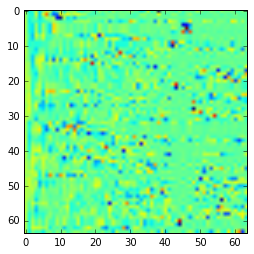

In [67]:
import matplotlib.pyplot as mplot

# mplot.imshow(X=v)
# mplot.imshow(X=v_post)
mplot.imshow(X=v_pre)
mplot.show()

b) Plot topographical maps and time courses of the first four components. 

To construct the PCA time courses, multiply the PCA weights defined by the pre- and post-trial time windows with the electrode time courses from the entire trial. 

Do you notice any differences in the topographical maps or time courses from before versus after stimulus onset? 

How would you interpret differences and/or similarities?

Note: Make the colormaps in ‘jet’ format and keep the color limit for the topoplots for both
conditions (i.e. pre- and post-stimulus) the same

In [208]:
# Use the topoplot.m function for plotting the head plots.
# Creating mne Objects from numpy arrays for Visualizing the epochs/ topomap plot
import mne as mne

labels = []
XYZs = []
eeg = sampleEEGdata['EEG'][0, 0]
eeg['chanlocs']['labels'][0, 0][0]
eeg['chanlocs']['labels'].shape[1]
for idx in range(eeg['chanlocs']['labels'].shape[1]):
    # channel labels or electrode labels
    label = eeg['chanlocs']['labels'][0, idx][0]
    #     print(label)
    labels.append(label)
    
    # channel location or electrode location
    X = eeg['chanlocs']['X'][0, idx][0][0]
    Y = eeg['chanlocs']['Y'][0, idx][0][0]
    Z = eeg['chanlocs']['Z'][0, idx][0][0]
    XYZs.append(np.array([X, Y, Z], dtype=float))

ch_location = np.array(XYZs, dtype=float) # channels or electrodes location
ch_names = labels # mat['ch_names'].tolist(): channels or electrodes names/ labels
dig_ch_pos = dict(zip(ch_names, ch_location))
montage = mne.channels.DigMontage(dig_ch_pos=dig_ch_pos)

sfreq = eeg['srate'][0, 0]

# It is also possible to use info from another raw object.
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)

tmin = eeg['xmin'][0, 0]
tmax = eeg['xmax'][0, 0]
picks = mne.pick_types(info=info, eeg=True)

In [209]:
# An MNE example for plotting PCA 
# pca = UnsupervisedSpatialFilter(PCA(30), average=False)
# pca_data = pca.fit_transform(X)
# ev = mne.EvokedArray(np.mean(pca_data, axis=0),
#                      mne.create_info(30, epochs.info['sfreq'],
#                                      ch_types='eeg'), tmin=tmin)
# ev.plot(show=False, window_title="PCA")

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


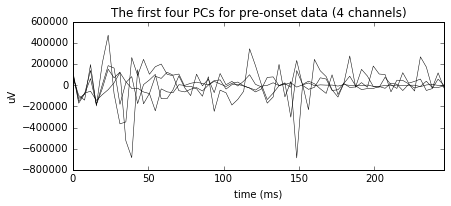

In [210]:
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
evoked = mne.EvokedArray(data=v_pre[:4], info=info)
evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


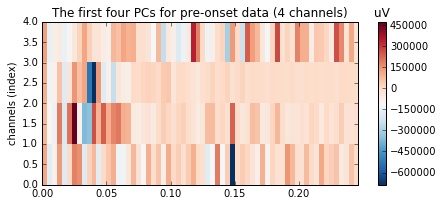

In [211]:
evoked.plot_image(show=False, titles='The first four PCs for pre-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


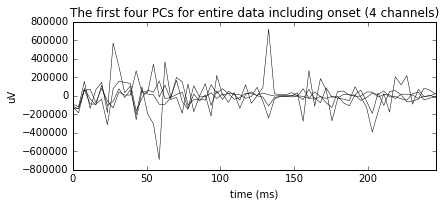

In [212]:
evoked = mne.EvokedArray(data=v[:4], info=info)
evoked.plot(show=False, window_title='window title', titles='The first four PCs for entire data including onset')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


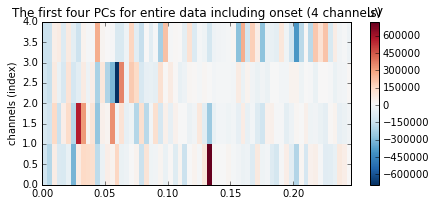

In [213]:
evoked.plot_image(show=False, titles='The first four PCs for entire data including onset')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


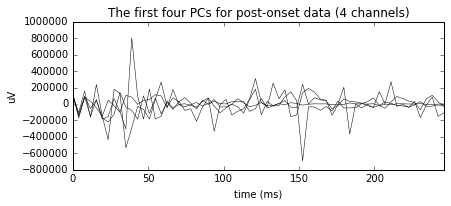

In [214]:
evoked = mne.EvokedArray(data=v_post[:4], info=info)
evoked.plot(show=False, window_title='window title', titles='The first four PCs for post-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


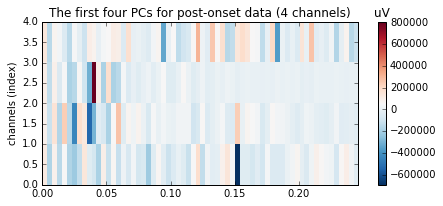

In [215]:
evoked.plot_image(show=False, titles='The first four PCs for post-onset data')

In [217]:
# # Visualizig in topoplot in the first four principle components
# # b) Plot topographical maps and time courses of the first four components. 
# # To construct the PCA time courses, 
# # multiply the PCA weights defined by the pre- and post-trial time windows 
# # with the electrode time courses from the entire trial. 
# v.shape, data[0].shape, v[:4].shape, 
# w, 
# w_post,
# w_pre

# The first 4 PCs and the first trial as an example, the entire trial
proj_pre = v_pre[:4] @ data_norm[0]
proj_post = v_post[:4] @ data_norm[0]
proj = v[:4] @ data_norm[0]
# proj.shape, proj_post.shape, proj_pre.shape

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


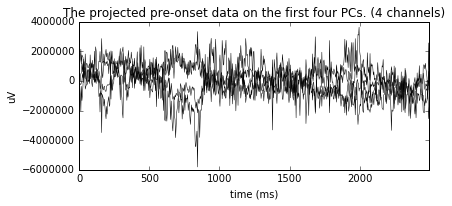

In [228]:
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
evoked = mne.EvokedArray(data=proj_pre, info=info)
evoked.plot(show=False, window_title='window title', titles='The projected pre-onset data on the first four PCs.')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


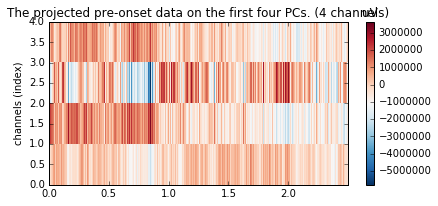

In [229]:
evoked.plot_image(show=False, titles='The projected pre-onset data on the first four PCs.')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


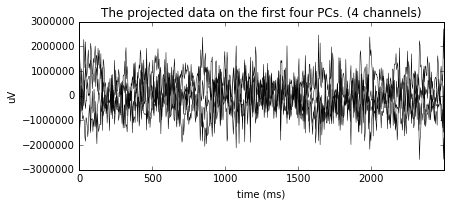

In [230]:
evoked = mne.EvokedArray(data=proj, info=info)
evoked.plot(show=False, window_title='window title', titles='The projected data on the first four PCs.')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


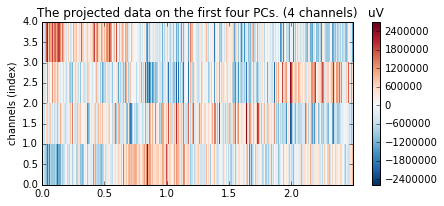

In [231]:
evoked.plot_image(show=False, titles='The projected data on the first four PCs.')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


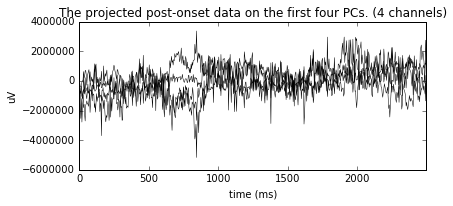

In [232]:
evoked = mne.EvokedArray(data=proj_post, info=info)
evoked.plot(show=False, window_title='window title', titles='The projected post-onset data on the first four PCs.')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


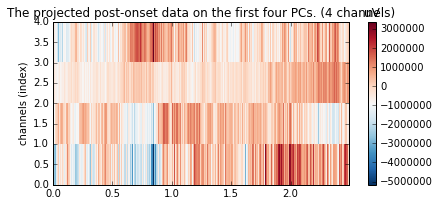

In [233]:
evoked.plot_image(show=False, titles='The projected post-onset data on the first four PCs.')

In [235]:
# v.shape, data_norm.shape
proj = v @ data_norm[0]
proj_pre = v_pre @ data_norm[0]
proj_post = v_post @ data_norm[0]
proj.shape, proj_pre.shape, proj_post.shape

((64, 640), (64, 640), (64, 640))

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


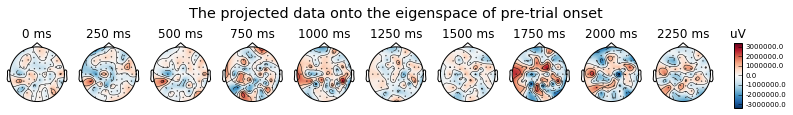

In [236]:
# It is also possible to use info from another raw object.
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)
evoked = mne.EvokedArray(data=proj_pre, info=info)
times = np.arange(0.0, 2.5, 0.25)
evoked.plot_topomap(show=False, times=times, title='The projected data onto the eigenspace of pre-trial onset')
# evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


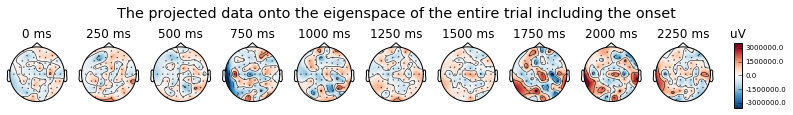

In [238]:
# It is also possible to use info from another raw object.
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)
evoked = mne.EvokedArray(data=proj, info=info)
evoked.plot_topomap(show=False, times=times, title='The projected data onto the eigenspace of the entire trial including the onset')
# evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


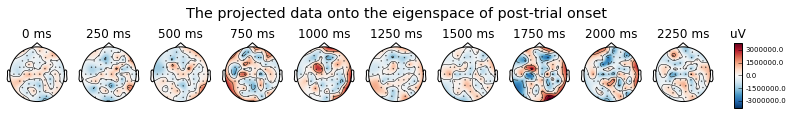

In [239]:
# It is also possible to use info from another raw object.
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)
evoked = mne.EvokedArray(data=proj_post, info=info)
evoked.plot_topomap(show=False, times=times, title='The projected data onto the eigenspace of post-trial onset')
# evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')

In [240]:
# v.shape, data_norm.shape
proj, proj_post, proj_pre = 0, 0, 0
for idx_trial in range(data_norm.shape[0]):
    proj += (v @ data_norm[idx_trial])/ data_norm.shape[0]
    proj_pre += (v_pre @ data_norm[idx_trial])/ data_norm.shape[0]
    proj_post += (v_post @ data_norm[idx_trial])/ data_norm.shape[0]
    # proj.shape, proj_pre.shape, proj_post.shape

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


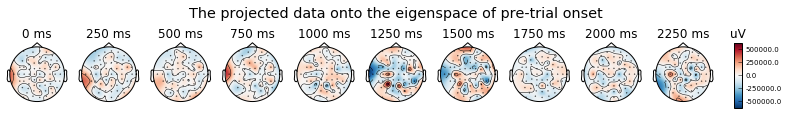

In [241]:
# It is also possible to use info from another raw object.
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)
evoked = mne.EvokedArray(data=proj_pre, info=info)
times = np.arange(0.0, 2.5, 0.25)
evoked.plot_topomap(show=False, times=times, title='The projected data onto the eigenspace of pre-trial onset')
# evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


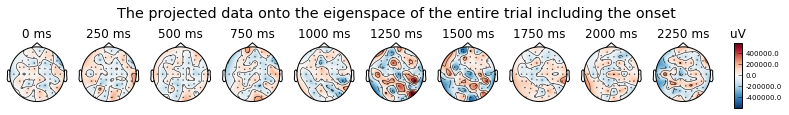

In [242]:
# It is also possible to use info from another raw object.
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)
evoked = mne.EvokedArray(data=proj, info=info)
evoked.plot_topomap(show=False, times=times, title='The projected data onto the eigenspace of the entire trial including the onset')
# evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


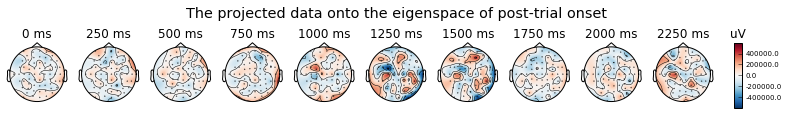

In [243]:
# It is also possible to use info from another raw object.
# info = mne.create_info(ch_names, sfreq, ch_types=None, montage=None, verbose=None)
# info = mne.create_info(ch_names=4, sfreq=sfreq, ch_types='eeg')
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=montage, sfreq=sfreq)
evoked = mne.EvokedArray(data=proj_post, info=info)
evoked.plot_topomap(show=False, times=times, title='The projected data onto the eigenspace of post-trial onset')
# evoked.plot(show=False, window_title='window title', titles='The first four PCs for pre-onset data')